### Importação das Bibliotecas

In [5]:
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import cv2

from numpy.core.numeric import NaN
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier as mlp
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPRegressor 
from sklearn import metrics
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.tree import export_text #export the decision rules
#from google.colab.patches import cv2_imshow

from sklearn.tree import export_graphviz
import six
import sys
sys.modules['sklearn.externals.six'] = six
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

#from sklearn.tree import DecisionTreeClassifier as tree

warnings.filterwarnings("ignore")

# <><><><><><><><> Parâmetros <><><><><><><><>
p_normalizacao = 0  # 0(não normalizado), 1(desvio padrão), 2(escala 0 a 1)

t_discre = "uniform"
#‘uniform’: All bins in each feature have identical widths.
#‘quantile’: All bins in each feature have the same number of points.
#‘kmeans’: Values in each bin have the same nearest center of a 1D k-means cluster.


v_variation = 0.02

num_grupos = 4      # 0(pela classe)

qtd_faixas = 2      # 0(automático) 

n_base = "seeds"

t_sel_att = "Regressao MLP"
# Regressao MLP
# Classificador MLP
# Mutual Info

qtd_teste = 0.3 # Porcentagem de dados para teste no seletor de atributos supervisionado



### Carregamento e Preparação das Bases

In [12]:
scaler = StandardScaler()
trans = MinMaxScaler()

if n_base == "iris":
  bb = sns.load_dataset(n_base)

if n_base == 'seeds':
  bb = pd.read_csv("seeds.csv", on_bad_lines='skip')

if n_base == 'glass':
  bb = pd.read_csv("glass.csv",on_bad_lines='skip')

if n_base == 'wine':
  bb = pd.read_csv("wine.csv",on_bad_lines='skip')

if n_base == 'cancer_mama':
  bb = pd.read_csv("cancermama.csv",sep=",")
  bb = bb.iloc[: , :-1]
  col_list = list(bb)
  columns_titles = ['id', 'fractal_dimension_worst', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'diagnosis']
  bb=bb.reindex(columns=columns_titles)


#pin = sns.load_dataset('penguins')
#iris.head()
#pin.head()
#pin.tail()
base_original = bb
print("=========> Base Original <=========\n",base_original)
#print("Descrição dos Dados:\n", base_original.describe())

# --> Remove nulls <--
data = base_original.dropna()
data = data.reset_index(drop = True)


if(num_grupos == 0): #<><><><><> Se a classe for o grupo <><><><><><>
  #print(data.columns[-1])
  #data[data.columns[-1]] = data[data.columns[-1]].map({0:'X'}, na_action='ignore')
  data[data.columns[-1]].replace(0, 'X', inplace = True)
  att_classe = data.iloc[: , -1]
  att_classe = att_classe.unique()
  qtd_classes = 0
  for item in att_classe:
    #print(item,i)
    #data.replace(to_replace=item, value=str(i))
    #data["species"].replace("setosa","kjkj", regex=True)
    data[data.columns[-1]].replace({item: qtd_classes}, inplace=True)
    qtd_classes = qtd_classes + 1
  data.columns = [*data.columns[:-1], 'grupo']
else:
  # --> Apagar Colunas classe <--
  if num_grupos > 0:
    #att_classe = "species"
    data = data.iloc[: , :-1] # Apaga o atributo classe (última coluna)


# Apaga o atributo ID
if 'ID' in data.columns:    
  data = data.drop(columns=["ID"]) 
if 'id' in data.columns: 
  data = data.drop(columns=["id"]) 

base_original = data

# --> Normalização <--
colunas = list(data.columns.values)
#print (colunas) 
n_normalizacao = "Sem Normalização"
if(p_normalizacao == 1):
  data = scaler.fit_transform(data)
  n_normalizacao = "Desvio Padrão"
if(p_normalizacao == 2):
  data = trans.fit_transform(data)
  n_normalizacao = "Escala 0-1"

data = pd.DataFrame(data, columns = colunas)

print("\n\n\n")
print("=========> Base Modificada <=========\n",data)
#print("Descrição dos Dados:\n", data.describe())


=========> Base Original <=========
      15.26  14.84   0.871  5.763  3.312  2.221   5.22  1
0    14.88  14.57  0.8811  5.554  3.333  1.018  4.956  1
1    14.29  14.09  0.9050  5.291  3.337  2.699  4.825  1
2    13.84  13.94  0.8955  5.324  3.379  2.259  4.805  1
3    16.14  14.99  0.9034  5.658  3.562  1.355  5.175  1
4    14.38  14.21  0.8951  5.386  3.312  2.462  4.956  1
..     ...    ...     ...    ...    ...    ...    ... ..
193  12.19  13.20  0.8783  5.137  2.981  3.631  4.870  3
194  11.23  12.88  0.8511  5.140  2.795  4.325  5.003  3
195  13.20  13.66  0.8883  5.236  3.232  8.315  5.056  3
196  11.84  13.21  0.8521  5.175  2.836  3.598  5.044  3
197  12.30  13.34  0.8684  5.243  2.974  5.637  5.063  3

[198 rows x 8 columns]




=========> Base Modificada <=========
      15.26  14.84   0.871  5.763  3.312  2.221   5.22
0    14.88  14.57  0.8811  5.554  3.333  1.018  4.956
1    14.29  14.09  0.9050  5.291  3.337  2.699  4.825
2    13.84  13.94  0.8955  5.324  3.379  2.259  4.

### Uso do K-Means

In [13]:
if(num_grupos != 0): #<><><><><> Se a classe for o grupo <><><><><><>
    grupos = KMeans(num_grupos, random_state=0).fit(data)
    data = base_original
    data['grupo'] = grupos.labels_ # Cria uma coluna com o grupo de cada registro
    print("====> Base com Grupos <====\n\n",data)

print('Quantidade de Registros em cada Grupo:\n', data['grupo'].value_counts())



====> Base com Grupos <====

      15.26  14.84   0.871  5.763  3.312  2.221   5.22  grupo
0    14.88  14.57  0.8811  5.554  3.333  1.018  4.956      2
1    14.29  14.09  0.9050  5.291  3.337  2.699  4.825      2
2    13.84  13.94  0.8955  5.324  3.379  2.259  4.805      2
3    16.14  14.99  0.9034  5.658  3.562  1.355  5.175      2
4    14.38  14.21  0.8951  5.386  3.312  2.462  4.956      2
..     ...    ...     ...    ...    ...    ...    ...    ...
193  12.19  13.20  0.8783  5.137  2.981  3.631  4.870      1
194  11.23  12.88  0.8511  5.140  2.795  4.325  5.003      1
195  13.20  13.66  0.8883  5.236  3.232  8.315  5.056      1
196  11.84  13.21  0.8521  5.175  2.836  3.598  5.044      1
197  12.30  13.34  0.8684  5.243  2.974  5.637  5.063      1

[198 rows x 8 columns]
Quantidade de Registros em cada Grupo:
 1    69
2    53
0    47
3    29
Name: grupo, dtype: int64


### **Seleção de Atributos**

In [ ]:
if (t_sel_att == "Classificador MLP") or (t_sel_att == "Regressao MLP"):

  v_grupo = []
  v_attr = []
  v_accu = []

  t_grupos = data['grupo'].unique()
  qtd_grupos = len(t_grupos)
  #print(qtd_grupos)

  ##### Para cada Grupo #####
  for iGrupos in t_grupos:    
    #print("\n\n############ Grupo: ", iGrupos, " ############")
    base = data.query("grupo == "+str(iGrupos))
    base = base.drop(columns=['grupo']) # Apaga o grupo
    #print(base)


    qtd_col = data.columns.size - 1   
    ##### Para cada coluna #####
    for i_col in range(0, qtd_col):

      treino, teste = train_test_split(base, test_size = qtd_teste)
      Y_train = treino.iloc[:, i_col]
      Y_teste = teste.iloc[:, i_col]
      X_train = treino.drop(treino.columns[i_col], axis=1)
      X_teste = teste.drop(teste.columns[i_col], axis=1)
      #print(X_train)
      #print(Y_train)

      #### Predição
      if t_sel_att == "Classificador MLP":
        
        atributo = Y_train.name
        Y_train = np.asarray(Y_train, dtype="int_")
        
        #print(Y_train)
        #X_teste = np.asarray(X_teste, dtype="int_")
        
        clp = mlp(solver='sgd', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
        clp.fit(X_train,Y_train)
        Y_pred = clp.predict(X_teste)
        Y_teste = np.asarray(Y_teste, dtype="int_")
        
        cm = confusion_matrix(Y_pred, Y_teste)
        acuracia = accuracy(cm)

      #### Regressão  
      if t_sel_att == "Regressao MLP":
        
        atributo = Y_train.name

        model = MLPRegressor(solver='lbfgs',alpha=0.001,hidden_layer_sizes=(3,2))
        model.fit(X_train,Y_train)
        Y_pred = model.predict(X_teste)

        #print("Score : ", model.score(X_teste, Y_teste))
        
        #acuracia = 1-metrics.mean_squared_log_error(Y_teste, Y_pred)
        #acuracia = 1-metrics.mean_absolute_percentage_error(Y_teste, Y_pred)
        acuracia = 1-metrics.mean_squared_error(Y_teste, Y_pred)
        
        #print("Acerto médio de ", Y_train.name, ": ", acuracia)

      v_grupo.append(iGrupos)
      v_attr.append(atributo)
      v_accu.append(acuracia)


      ##### Fim para cada coluna #####


    ##### Fim para cada Grupo #####

  #coloca os resultados em uma matriz 
  v_resul = np.array([v_grupo, v_attr, v_accu])
  v_resul = v_resul.T
  v_resul = pd.DataFrame(v_resul, columns = [ 'grupo', 'atrib', 'accu' ])
  #v_resul = v_resul.reset_index()
  v_resul["accu"] = pd.to_numeric(v_resul["accu"])
  v_resul["grupo"] = pd.to_numeric(v_resul["grupo"])

  print(v_resul)

if (t_sel_att == "Mutual Info"):
  from sklearn.feature_selection import mutual_info_classif
  l_atrib = data.columns.to_list()
  l_atrib.pop()
  X = data.drop(columns=['grupo'])
  #print(X)
  y = data["grupo"]
  l_rank = mutual_info_classif(X, y, discrete_features=True)
  t_grupos = data['grupo'].unique()
  v_resul_f = []
  v_grupo_f = []
  v_attr_f = []
  v_accu_f = []
  count = 0
  g = 0
  for g in range(len(t_grupos)):
    #print("Grupo-->", t_grupos[g])
    for r in range(len(l_rank)):
      #print("Grupo: ", t_grupos[g], "Atributo: ", l_atrib[r], "Rank: ", l_rank[r])
      v_grupo_f.append(t_grupos[g])
      v_attr_f.append(l_atrib[r])
      v_accu_f.append(l_rank[r])
      #v_grupo_f[count] = t_grupos[g]
      #v_resul_f[count] = [g, l_atrib[r], l_rank[r]]
    #  print(count)
    #  v_resul_f[0] = [1, "sdsda", 8234]
      count = count + 1

  v_resul_f = np.array([v_grupo_f, v_attr_f, v_accu_f])
  v_resul_f = v_resul_f.T
  v_resul_f = pd.DataFrame(v_resul_f, columns = [ 'grupo', 'atrib', 'accu' ])
  #v_resul = v_resul.reset_index()
  v_resul_f["accu"] = pd.to_numeric(v_resul_f["accu"])
  v_resul_f["grupo"] = pd.to_numeric(v_resul_f["grupo"])
  v_resul = v_resul_f
  print (v_resul)

    grupo                 atrib      accu
0       1                  area  0.986545
1       1             perimeter  0.874221
2       1           compactness  0.999769
3       1        lengthOfKernel  0.971982
4       1         widthOfKernel  0.998155
5       1  asymmetryCoefficient -1.955264
6       1  lengthOfKernelGroove  0.935198
7       3                  area  0.145629
8       3             perimeter  0.612823
9       3           compactness  0.999687
10      3        lengthOfKernel  0.967439
11      3         widthOfKernel  0.997085
12      3  asymmetryCoefficient  0.113368
13      3  lengthOfKernelGroove  0.967194
14      0                  area  0.995870
15      0             perimeter  0.862189
16      0           compactness  0.999331
17      0        lengthOfKernel  0.984837
18      0         widthOfKernel  0.997321
19      0  asymmetryCoefficient  0.558746
20      0  lengthOfKernelGroove  0.991577
21      2                  area  0.971834
22      2             perimeter  0

### Rotulação Baseada em Lopes

In [ ]:

def accuracy(confusion_matrix):
   diagonal_sum = confusion_matrix.trace()
   sum_of_all_elements = confusion_matrix.sum()
   return (diagonal_sum / sum_of_all_elements)*100

#print(data)
print('\033[1m', "<><><><><><> Parâmetros <><><><><><><>", '\033[0m')
print("Nome da Base:", n_base)
print("Tipo de Normalização:", n_normalizacao)
print("Variação V:", v_variation)
if (num_grupos == 0):
  print("Número de Grupos(formados pela classe):", qtd_classes)
else:
  print("Número de Grupos(k):", num_grupos)
print("Quantidade de Faixas:", qtd_faixas)
print("Seleção de Atributos:", t_sel_att)



#<><><><><> Discretização <><><><><>
base = data.drop(columns=['grupo']) # Apaga o grupo
col_grupo = data["grupo"]
col_nomes = list(base.columns)

enc = KBinsDiscretizer(n_bins=qtd_faixas, strategy=t_discre, encode="ordinal")
base_d = enc.fit_transform(base)
base_d = pd.DataFrame(base_d,columns=col_nomes) 
base_d['grupo'] = col_grupo

#print(base_d)


#pega os atributos com acurácia até v_variation pior 
t_grupos = v_resul['grupo'].unique()
#print(t_grupos)
print('\033[1m', "\n<><><><><><><> Rótulos <><><><><><><>", '\033[0m')
iGrupos = 0
count = 0
##### Para cada Grupo #####
for iGrupos in t_grupos: 
  r_base = v_resul.query("grupo == "+str(iGrupos))
  #print("\nr_base:", r_base)
  #print("\nBase_d:\n", base_d)
  print("\n===> Grupo "+str(iGrupos), "(", data['grupo'].value_counts()[count],"elementos)")
  count = count+1
  #print(r_base)
  #best_att = r_base.loc[r_base['accu'] == r_base["accu"].max()]
  print(r_base["accu"].max())
  print((r_base["accu"].max()*v_variation))
  print((r_base["accu"].max())-(r_base["accu"].max()*v_variation))
  best_att = r_base.loc[r_base['accu'] >= r_base["accu"].max()-(r_base["accu"].max()*v_variation)]
  #print(r_base["accu"].max()-(r_base["accu"].max()*v_variation))
  
  #print(best_att)
  #print("\nBest_att:\n", best_att, "\n")

  for i in best_att.index:
    print("Atributo: ", best_att["atrib"][i] , "(",best_att["accu"][i],")")
    r_base = base_d.query("grupo == "+str(iGrupos))
    #print("\nr_base:\n", r_base)
    faixas = enc.bin_edges_[r_base.columns.get_loc(best_att["atrib"][i])] 
    melhor_faixa = r_base[best_att["atrib"][i]].value_counts()

    #print(r_base)
    acertos = r_base[best_att["atrib"][i]].value_counts().tolist()
    #print ("Acertos:", acertos)
    
    index = melhor_faixa.index
    indexNamesArr = melhor_faixa.index.values
    l_inter = list(indexNamesArr)
    indice_melhor = int(l_inter[0])
    
    tx_acerto = (acertos[0]*100)/len(r_base.index)

    print("Faixa: ", faixas[indice_melhor], "-", faixas[indice_melhor+1], "(", tx_acerto,")")
    
    
    #print(len(r_base.index))


  


##### Fim para cada Grupo #####




 <><><><><><> Parâmetros <><><><><><><> 
Nome da Base: seeds
Tipo de Normalização: Sem Normalização
Variação V: 0.02
Número de Grupos(k): 4
Quantidade de Faixas: 2
Seleção de Atributos: Regressao MLP
 
<><><><><><><> Rótulos <><><><><><><> 

===> Grupo 1 ( 66 elementos)
0.9997690401429212
0.019995380802858426
0.9797736593400628
Atributo:  area ( 0.986545223903756 )
Faixa:  10.59 - 15.885 ( 59.09090909090909 )
Atributo:  compactness ( 0.9997690401429212 )
Faixa:  0.8632 - 0.9183 ( 88.63636363636364 )
Atributo:  widthOfKernel ( 0.9981545454206596 )
Faixa:  3.3315 - 4.033 ( 68.18181818181819 )

===> Grupo 3 ( 44 elementos)
0.9996874428019716
0.019993748856039432
0.9796936939459322
Atributo:  compactness ( 0.9996874428019716 )
Faixa:  0.8632 - 0.9183 ( 71.73913043478261 )
Atributo:  widthOfKernel ( 0.9970853966284852 )
Faixa:  2.63 - 3.3315 ( 86.95652173913044 )

===> Grupo 0 ( 54 elementos)
0.99933101297119
0.0199866202594238
0.9793443927117662
Atributo:  area ( 0.995870002328022 )
Faixa:

### Rotulação Baseada em Árvore

dados:
     sepal_length sepal_width petal_length petal_width grupo
0            1.0         3.0          0.0         0.0     1
1            0.0         2.0          0.0         0.0     1
2            0.0         2.0          0.0         0.0     1
3            0.0         2.0          0.0         0.0     1
4            0.0         3.0          0.0         0.0     1
..           ...         ...          ...         ...   ...
145          3.0         2.0          3.0         4.0     2
146          2.0         1.0          3.0         3.0     0
147          3.0         2.0          3.0         3.0     2
148          2.0         2.0          3.0         4.0     2
149          2.0         2.0          3.0         3.0     0

[150 rows x 5 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sepal_length  150 non-null    object
 1   sepal_width  

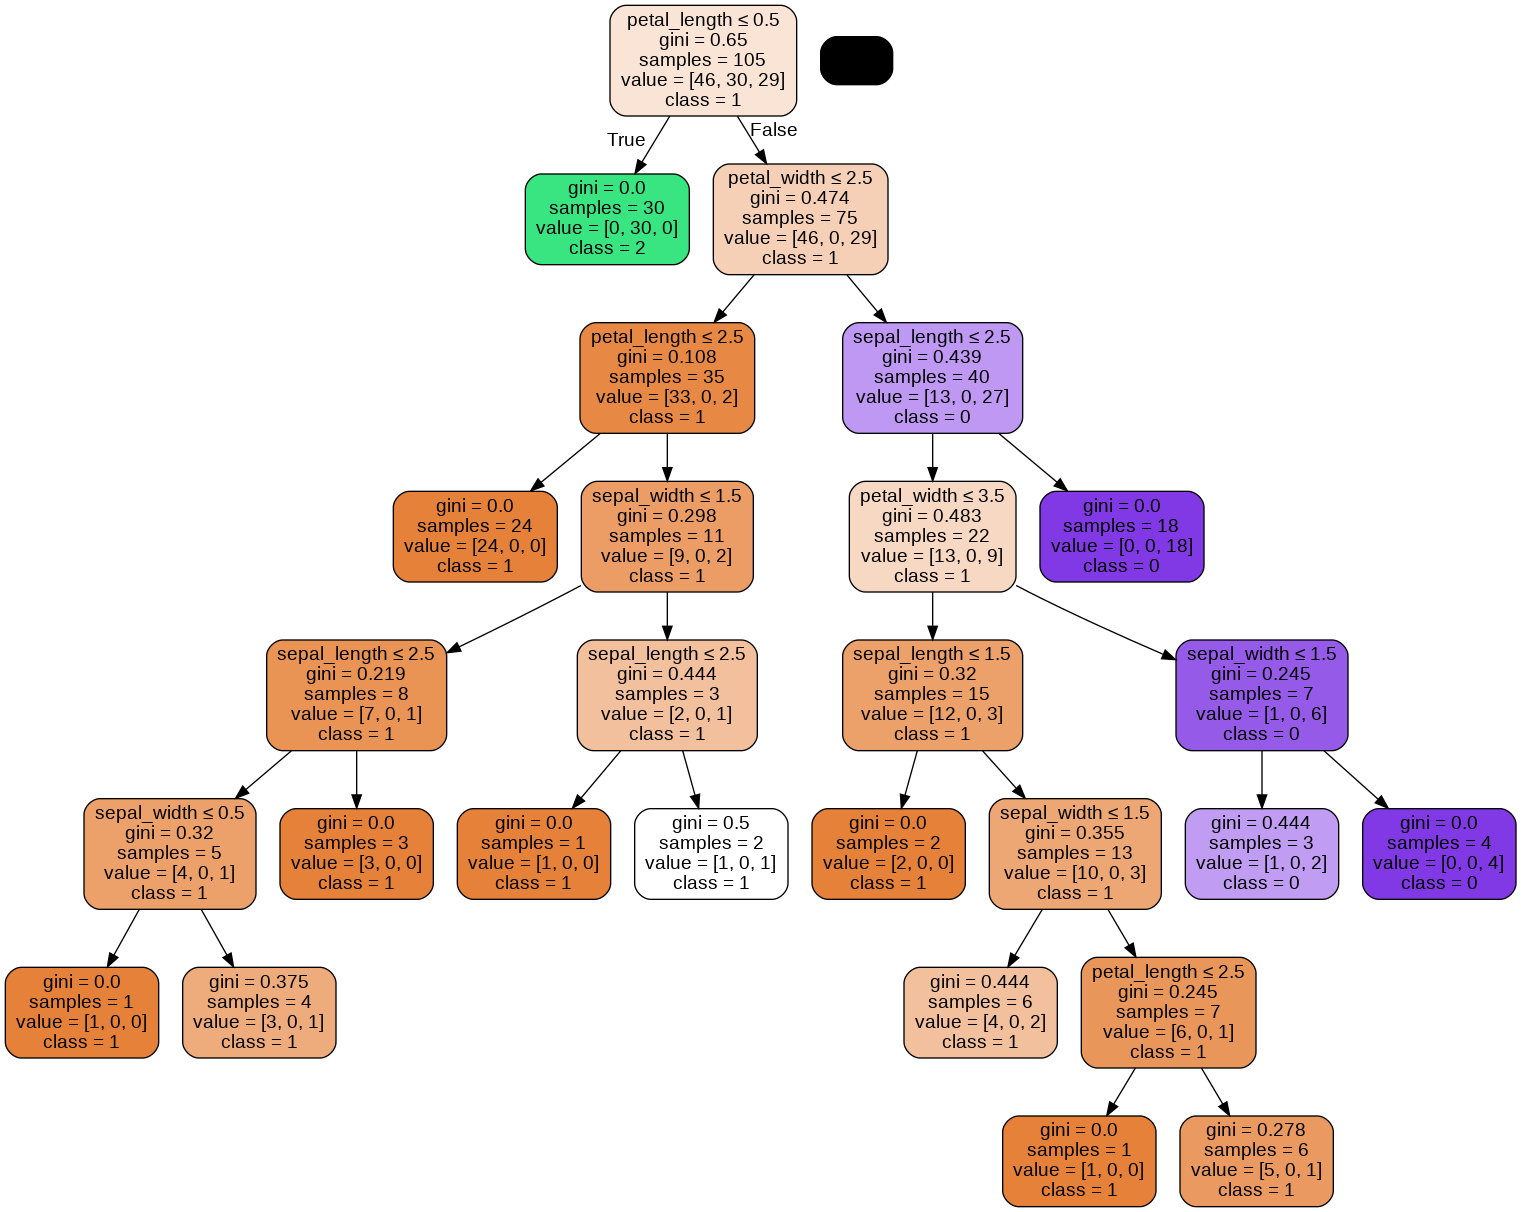

petal_length
0.5


In [ ]:
t_saida_arv = 1 # 1 --> Grafica  // 0 --> Texto

#print(data)

if qtd_faixas != 0:
#<><><><><> Discretização <><><><><>
  base = data.drop(columns=['grupo']) # Apaga o grupo
  col_grupo = data["grupo"]
  col_nomes = list(base.columns)

  enc = KBinsDiscretizer(n_bins=qtd_faixas, strategy=t_discre, encode="ordinal")
  base_d = enc.fit_transform(base)
  base_d = pd.DataFrame(base_d,columns=col_nomes) 
  base_d['grupo'] = col_grupo

  #base_d.apply(base_d.to_numeric, errors='ignore')
  base_d = base_d.astype(str)

  data = base_d
  print("dados:\n",data)
  print(data.info())


i_col = data.columns.size 

print(i_col-1)

treino, teste = train_test_split(data, test_size = qtd_teste)
Y_train = treino.iloc[:, i_col-1]
Y_teste = teste.iloc[:, i_col-1]
X_train = treino.drop(treino.columns[i_col-1], axis=1)
X_teste = teste.drop(teste.columns[i_col-1], axis=1)

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,Y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_teste)

print("\nAcurácia da Árvore:",metrics.accuracy_score(Y_teste, y_pred), "\n")


feature_cols = X_teste.columns.to_list()
class_names = Y_teste.unique()

if(t_saida_arv == 1):
  
  acs = [str(x) for x in class_names]
  dot_data = StringIO()
  export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True,feature_names = feature_cols,class_names=acs)
  graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
  graph.write_png(n_base+'.png')
  Image(graph.create_png())
  
  img = cv2.imread(n_base+'.png')
  cv2_imshow(img)

else:
  tree_rules = export_text(clf, feature_names = feature_cols) #print the result
  print(tree_rules)

print(feature_cols[clf.tree_.feature[0]])
print(clf.tree_.threshold[0])





### Plotagem de Gráficos

In [ ]:

 # x = pin['bill_depth_mm']
 # y = pin['bill_length_mm']
x = data['grupo']
y = data["petal_width"]
z = data['petal_length']

#sns.scatterplot(y,z) # ---> Gráfico Comum
# plt.pie(x) # ---> Gráfico em Pizza

fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
ax.scatter(x, y, z, c=x, marker='o')

ax.set_xlabel(x.name)
ax.set_ylabel(y.name)
ax.set_zlabel(z.name)

plt.show()

# sns.pairplot(data, hue="grupo")

KeyError: ignored